# Matched Discrimination Analysis

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.linear_model import LinearRegression


## Load in data 

In [5]:
# _dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination'
_dir = '/Users/prachi/Documents/depth_duration/depth_discrimination'
raw_dir = _dir + '/data/finalDiscrimMatched/raw'

final_discrim = pd.read_csv (raw_dir + '/final_discrim.csv')


In [10]:
final_discrim

,Unnamed: 0,subjID,workerId,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,...,trial_RT,log_fixation,log_sceneDuration1,log_mask1,log_sceneDuration2,log_mask2,experimentTime,totalTime,age,gender
0,86,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,...,1413.0,1014.0,247.0,992.0,253.0,496.0,NaN,475685,28,Man
1,87,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,...,1180.0,1003.0,262.0,998.0,253.0,486.0,NaN,475685,28,Man
2,88,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,...,1094.0,1015.0,248.0,1002.0,248.0,500.0,NaN,475685,28,Man
3,89,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,...,1233.0,1012.0,250.0,1000.0,254.0,487.0,NaN,475685,28,Man
4,90,388370.0,A39XIQCFSCNHFU,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim250_randls_5_rotated.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,307.0,1553.0,789.0,...,1196.0,1016.0,234.0,1000.0,265.0,498.0,NaN,475685,28,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35438,88661,208241.0,AI4AO0O0WIJF7,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim125_randls_13.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,293.0,1536.0,722.0,...,1008.0,1002.0,129.0,1009.0,110.0,505.0,NaN,438148,47,Woman
35439,88662,208241.0,AI4AO0O0WIJF7,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim125_randls_13.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,293.0,1536.0,722.0,...,1162.0,1013.0,121.0,999.0,133.0,499.0,NaN,438148,47,Woman
35440,88663,208241.0,AI4AO0O0WIJF7,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim125_randls_13.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,293.0,1536.0,722.0,...,1064.0,1011.0,126.0,994.0,124.0,496.0,NaN,438148,47,Woman
35441,88664,208241.0,AI4AO0O0WIJF7,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim125_randls_13.json,http://54.235.29.9/FacialAge/BNav_EC2/DepthDur...,293.0,1536.0,722.0,...,1098.0,1001.0,126.0,1006.0,125.0,502.0,NaN,438148,47,Woman


# Correlation with Verbal Report data 

- For each discrimination trial, get the average difference between the verbal report for those scenes 
- Correlate that with the proportion correct for that trial 
- Is there better accuracy for scenes that have a larger percevied depth difference (using the verbal report data)?

## Individual Discriminations

In [11]:
def get_accuracy(df):
    """
    * ACCURACY BASED ON THE KINECT
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    
    return count_correct/count_total, count_correct, count_total, count_missed

def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        list_RTs.append(row["trial_RT"])
    
    list_RTs = np.array(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)

In [15]:
final_discrim_125 = final_discrim.loc[final_discrim['duration'] == 125]
final_discrim_250 = final_discrim.loc[final_discrim['duration'] == 250]
final_discrim_1000 = final_discrim.loc[final_discrim['duration'] == 1000]

In [16]:
overall_accuracy = get_accuracy(final_discrim)
overall_accuracy

(0.5961659513590845, 20836, 34950, 493)

In [17]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = [elem for elem in df.stimulus_0.unique() if type(elem) == str]

    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
                
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        kinect_answer = stim0_df.kinect_answer.unique()[0]
        
        try:
            stim_acc_125 = get_accuracy(stim_125_df)
            stim_acc_250 = get_accuracy(stim_250_df)
            stim_acc_1000 = get_accuracy(stim_1000_df)

            stim_RT_125 = get_RT(stim_125_df)
            stim_RT_250 = get_RT(stim_250_df)
            stim_RT_1000 = get_RT(stim_1000_df)

            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'RT_125': stim_RT_125,
                                    'accuracy_250': stim_acc_250,
                                    'RT_250': stim_RT_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'RT_1000': stim_RT_1000,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'kinect_answer': kinect_answer}
        except:
            pass
    
    return stimuli_stats

In [18]:
all_discrim_performance = individual_discrimination_stats(final_discrim)


In [20]:
# all_discrim_performance['depth_discrimination_stimuli/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png']



## Load Raw TAC Verbal Judgement Data


In [21]:
# p = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/raw/'
p = '/Users/prachi/Documents/depth_duration/verbal_judgement_analysis/data/finalVEMatched/raw/'
# x data
with open(p + 'X_125.npy' , 'rb') as f:
    n_TAC_X_125 = np.load(f, allow_pickle=True)
    
with open(p + 'X_250.npy' , 'rb') as f:
    n_TAC_X_250 = np.load(f, allow_pickle=True)

with open(p + 'X_1000.npy' , 'rb') as f:
    n_TAC_X_1000 = np.load(f, allow_pickle=True)
    
# y data 
with open(p + 'final_y_125.npy' , 'rb') as f:
    n_TAC_final_y_125 = np.load(f, allow_pickle=True)
    
with open(p + 'final_y_250.npy' , 'rb') as f:
    n_TAC_final_y_250 = np.load(f, allow_pickle=True)
    
with open(p + 'final_y_1000.npy' , 'rb') as f:
    n_TAC_final_y_1000= np.load(f, allow_pickle=True)

# std data
with open(p + 'std_125.npy' , 'rb') as f:
    n_TAC_std_125 = np.load(f, allow_pickle=True)
    
with open(p + 'std_250.npy' , 'rb') as f:
    n_TAC_std_250 = np.load(f, allow_pickle=True)

with open(p + 'std_1000.npy' , 'rb') as f:
    n_TAC_std_1000 = np.load(f, allow_pickle=True)
    
# ste data
with open(p + 'ste_125.npy' , 'rb') as f:
    n_TAC_ste_125 = np.load(f, allow_pickle=True)
    
with open(p + 'ste_250.npy' , 'rb') as f:
    n_TAC_ste_250 = np.load(f, allow_pickle=True)

with open(p + 'ste_1000.npy' , 'rb') as f:
    n_TAC_ste_1000 = np.load(f, allow_pickle=True)

# stim data
with open(p + 'final_stim_125.npy' , 'rb') as f:
    n_TAC_final_stim_125 = np.load(f, allow_pickle=True)
    
with open(p + 'final_stim_250.npy' , 'rb') as f:
    n_TAC_final_stim_250 = np.load(f, allow_pickle=True)

with open(p + 'final_stim_1000.npy' , 'rb') as f:
    n_TAC_final_stim_1000 = np.load(f, allow_pickle=True)

# Code depth discrimination correctness by the verbal judgement data 

Create new 'ground truth' answer based on verbal judgement data

Task: Respond which image's target was closer to you

## VE Data

In [22]:
n_VE_answerkey_125 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_125 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_125[idx0]
    std0 = n_TAC_std_125[idx0]
    ste0 = n_TAC_ste_125[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_125 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_125[idx1]
    std1 = n_TAC_std_125[idx1]
    ste1 = n_TAC_ste_125[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_125[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}

In [30]:
# n_VE_answerkey_125

In [23]:
n_VE_answerkey_250 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_250 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_250[idx0]
    std0 = n_TAC_std_250[idx0]
    ste0 = n_TAC_ste_250[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_250 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_250[idx1]
    std1 = n_TAC_std_250[idx1]
    ste1 = n_TAC_ste_250[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_250[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [24]:
# len(n_VE_answerkey_250), n_VE_answerkey_250['depth_discrimination_stimuli/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1-target.png']
# n_VE_answerkey_250

In [25]:
n_VE_answerkey_1000 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_1000 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_1000[idx0]
    std0 = n_TAC_std_1000[idx0]

    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_1000 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_1000[idx1]
    std1 = n_TAC_std_1000[idx1]
    
    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]



    n_VE_answerkey_1000[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [26]:
len(n_VE_answerkey_1000)

156

In [775]:
import pickle
# save answer keys as pickle file 

# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_1000.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_1000, handle)

In [776]:
# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_250.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_250, handle)

### VE Coded Accuracy

In [27]:
def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    
    VE_correct_answer = answerkey[stim0]['answer']
    kinect_correct_answer = answerkey[stim0]['kinect_answer']
    
    for idx, row in df.iterrows(): 
        choice = row["discrim_choice"]
        count_total += 1
        if choice == 0.0:
            image_choice = row["stimulus_0"]
                
        if choice == 1.0:
            image_choice = row["stimulus_1"]
                
        if choice == 2.0:
            count_missed += 1
            
        if choice == 3.0:
            count_missed += 1
        
        try:
            if image_choice.split('/')[-1] == VE_correct_answer:
                count_correct += 1
        except:
            pass
        
#     standardError = (0.5*(1-0.5))/count_total
    p = count_correct/count_total
    standardError = np.sqrt((p*(1-p))/count_total)
    
    if VE_correct_answer == kinect_correct_answer:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'pos'
    else:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'neg'

    
def main_VE_accuracy(df, answerkey_125, answerkey_250, answerkey_1000):
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        try:
            # dataframe for stimulus 0
            stim0_df = df.loc[df['stimulus_0'] == stim0]
            # name of stimulus 1
            other_stim = stim0_df.stimulus_1.unique()[0]
            # dataframe where stimulus 0 is presented SECOND (same trial)
            stim1_df = df.loc[df['stimulus_1'] == stim0]

            # df for a specific discrimination trial (collapsed on stim presentation order)
            stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
            stim_125_df = stim_df[stim_df['duration'] == 125.0]
            stim_250_df = stim_df[stim_df['duration'] == 250.0]
            stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 

            stim0_depth = stim_df['actual_depth_0'][0]
            stim1_depth = stim_df['actual_depth_1'][0]
            stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))

            stim_acc_125 = VE_accuracy(stim0, stim_125_df, answerkey_125)
            stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
            stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)

            # difference between verbal judgements divided by joint variance 
            # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
            std0_125 = answerkey_125[stim0]['std0']
            std1_125 = answerkey_125[stim0]['std1']
            joint_variance_125 = np.sqrt(std0_125**2 + std1_125**2)
            JV_regressor_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])/joint_variance_125

            std0_250 = answerkey_250[stim0]['std0']
            std1_250 = answerkey_250[stim0]['std1']
            joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
            JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250

            std0_1000 = answerkey_1000[stim0]['std0']
            std1_1000 = answerkey_1000[stim0]['std1']
            joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
            JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
            if stim_acc_125[-1] == 'pos':
                VE_depthdifference_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_125 = -(abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_250[-1] == 'pos':
                VE_depthdifference_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_250 = -(abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_1000[-1] == 'pos':
                VE_depthdifference_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_1000 = -(abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']))
            
            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'accuracy_250': stim_acc_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'avg_depth': stim_depthbin,
                                    'VE_depthdifference_125': VE_depthdifference_125, 
                                    'VE_depthdifference_250': VE_depthdifference_250, 
                                    'VE_depthdifference_1000': VE_depthdifference_1000,
                                    'RT_125': get_RT(stim_125_df),
                                    'RT_250': get_RT(stim_250_df),
                                    'RT_1000': get_RT(stim_1000_df),
                                    'JV_regressor_125': JV_regressor_125,
                                    'JV_regressor_250': JV_regressor_250,
                                    'JV_regressor_1000': JV_regressor_1000,
                                    'kinect_answer_125': answerkey_125[stim0]['kinect_answer'],
                                    'kinect_answer_250': answerkey_250[stim0]['kinect_answer'],
                                    'kinect_answer_1000': answerkey_1000[stim0]['kinect_answer']}
            

        except:
            print(stim0)

    return stimuli_stats
    

In [28]:
n_all_VE_discrim_performance = main_VE_accuracy(final_discrim, n_VE_answerkey_125, n_VE_answerkey_250, n_VE_answerkey_1000) 

nan


## Subject Accuracy

In [29]:
subj_acc = {125: [], 250: [], 1000: []}
all_subj_acc_slopes = {125: [], 250: [], 1000: []}


aks = {125: n_VE_answerkey_125, 250: n_VE_answerkey_250, 1000: n_VE_answerkey_1000}

for subj in final_discrim.subjID.unique():
    
    subj_df = final_discrim.loc[final_discrim['subjID']==subj]
    s_duration = subj_df.duration.unique()[0]
    s_ak = aks[s_duration]
    
    s_stim = [elem for elem in subj_df.stimulus_0.unique() if type(elem) == str]
    
    count_total = 0
    count_correct = 0
    count_missed = 0
    
    subj_depthdiff = []
    subj_trial_acc = []    
        
    for stim0 in s_stim:
        VE_correct_answer = s_ak[stim0]['answer']
        kinect_correct_answer = s_ak[stim0]['kinect_answer']
        
        stim_df = subj_df.loc[subj_df['stimulus_0'] == stim0]
        choice = stim_df["discrim_choice"].unique()[0]

        count_total += 1
        if choice == 0.0: image_choice = stim_df["stimulus_0"].unique()[0]

        if choice == 1.0: image_choice = stim_df["stimulus_1"].unique()[0]

        if choice == 2.0: count_missed += 1

        if choice == 3.0: count_missed += 1

        if image_choice.split('/')[-1] == VE_correct_answer: 
            count_correct += 1
            subj_trial_acc.append(1)
        else:
            subj_trial_acc.append(0)
            
            
        

        depthdiff = n_all_VE_discrim_performance[stim0]['VE_depthdifference_' + str(int(s_duration))]
        subj_depthdiff.append(depthdiff)
        
    
    #run regression
    X = np.array(np.abs(subj_depthdiff).reshape(-1,1))
    y = subj_trial_acc
    reg = LinearRegression().fit(X, y)

    all_subj_acc_slopes[s_duration].append(reg.coef_[0])

        
    subj_acc[s_duration].append(count_correct/count_total)


    
    

In [31]:
import pickle
# save performance as pickle file 

dest = '/Users/prachi/Documents/depth_duration/depth_discrimination/data/finalDiscrimMatched/'
with open(dest + 'rawVE_coded_performance.pkl', 'wb') as handle:
    pickle.dump(n_all_VE_discrim_performance, handle)
    

In [83]:
n_VE_estim_diff_125 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_125'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_250 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_1000 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in n_all_VE_discrim_performance]

n_VE_accuracy_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in n_all_VE_discrim_performance]

n_VE_ste_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][-2] for elem in n_all_VE_discrim_performance]

# n_avg_RT_125 = [n_all_VE_discrim_performance[elem]['RT_125'][1] for elem in n_all_VE_discrim_performance]
# n_avg_RT_250 = [n_all_VE_discrim_performance[elem]['RT_250'][1] for elem in n_all_VE_discrim_performance]
# n_avg_RT_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][1] for elem in n_all_VE_discrim_performance]


n_avg_RT_125 = [n_all_VE_discrim_performance[elem]['RT_125'][1]-125 for elem in n_all_VE_discrim_performance]
n_avg_RT_250 = [n_all_VE_discrim_performance[elem]['RT_250'][1]-250 for elem in n_all_VE_discrim_performance]
n_avg_RT_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][1]-1000 for elem in n_all_VE_discrim_performance]


n_avg_RT_ste_125 = [n_all_VE_discrim_performance[elem]['RT_125'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_250 = [n_all_VE_discrim_performance[elem]['RT_250'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][-1] for elem in n_all_VE_discrim_performance]

n_JV_125 = [n_all_VE_discrim_performance[elem]['JV_regressor_125'] for elem in n_all_VE_discrim_performance]
n_JV_250 = [n_all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in n_all_VE_discrim_performance]
n_JV_1000 = [n_all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in n_all_VE_discrim_performance]

n_kinectanswer_125 = [n_all_VE_discrim_performance[elem]['kinect_answer_125'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_250 = [n_all_VE_discrim_performance[elem]['kinect_answer_250'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_1000 = [n_all_VE_discrim_performance[elem]['kinect_answer_1000'] for elem in n_all_VE_discrim_performance]

n_stim = [elem for elem in n_all_VE_discrim_performance]

#### Overall Accuracy: Coded by Raw VE


In [33]:
np.mean(n_VE_accuracy_125), np.mean(n_VE_accuracy_250), np.mean(n_VE_accuracy_1000)

(0.6641081068394928, 0.6635297958298388, 0.7415640005360911)

In [43]:
print('125 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference')
stats.pearsonr(n_VE_accuracy_125, n_VE_estim_diff_125)

125 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference


(0.41752825405939303, 5.869167975881784e-08)

In [44]:
print('250 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference')
stats.pearsonr(n_VE_accuracy_250, n_VE_estim_diff_250)

250 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference


(0.5794801831054321, 2.2711282715117934e-15)

In [45]:
print('1000 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference')
stats.pearsonr(n_VE_accuracy_1000, n_VE_estim_diff_1000)

1000 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference


(0.6727940920301484, 6.646409228152823e-22)

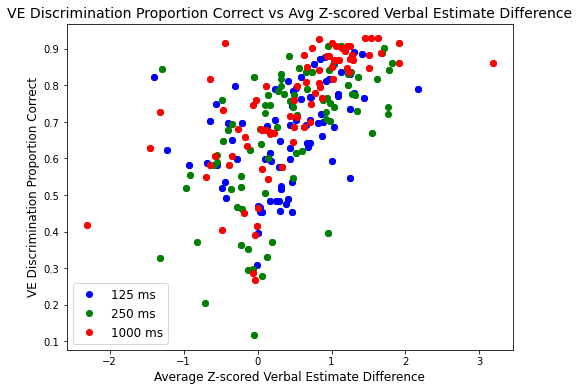

In [34]:
plt.figure(figsize=[8,6])
plt.plot(np.array(n_VE_estim_diff_125), np.array(n_VE_accuracy_125), 'bo', label='125 ms')
plt.plot(np.array(n_VE_estim_diff_250), np.array(n_VE_accuracy_250), 'go', label='250 ms')
plt.plot(np.array(n_VE_estim_diff_1000), np.array(n_VE_accuracy_1000), 'ro', label='1000 ms')
plt.xlabel('Average Z-scored Verbal Estimate Difference', fontsize=12)
plt.ylabel('VE Discrimination Proportion Correct', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('VE Discrimination Proportion Correct vs Avg Z-scored Verbal Estimate Difference', fontsize = 14)
plt.show();

In [47]:
# len(n_VE_accuracy_250)

In [36]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

m: [0.1927821]
b: 0.5423091919819153
R-squared:  0.35935592185207776


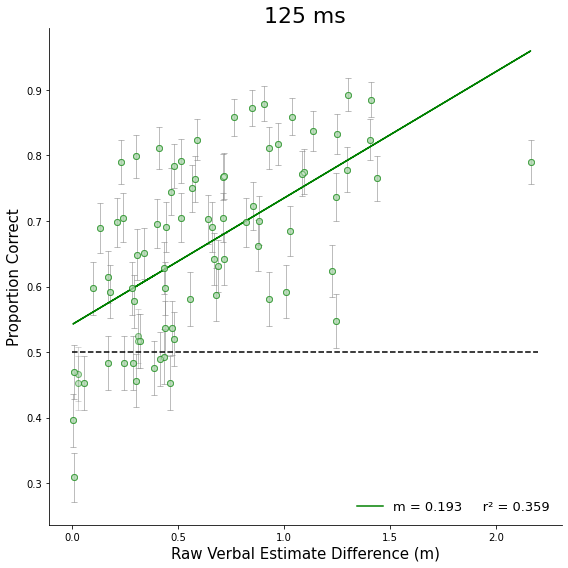

In [40]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


#run regression
VE_X_125 = np.array(np.abs(n_VE_estim_diff_125).reshape(-1,1))
VE_PC_125 = n_VE_accuracy_125
VE_PC_reg_125 = LinearRegression().fit(VE_X_125, VE_PC_125)

#Generated Predictions
PC_predicted_125 = VE_PC_reg_125.predict(VE_X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_125, VE_PC_125,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_125));


plt.plot(VE_X_125, VE_PC_125, 'o', color='green', alpha = 0.3);
plt.plot(VE_X_125, PC_predicted_125,color='green', label = 'm = ' + str(round(VE_PC_reg_125.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_125.score(VE_X_125, VE_PC_125)), 3)))
plt.xlabel("Raw Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

plt.plot([0, 2.2], [0.5,0.5], '--', color='black')



#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_125.coef_))
print("b: {0}".format(VE_PC_reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_125.score(VE_X_125, VE_PC_125))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

plt.title('125 ms', fontsize=22)

fig.tight_layout()

plt.show();

m: [0.17241512]
b: 0.5455887118432613
R-squared:  0.21695107911126632


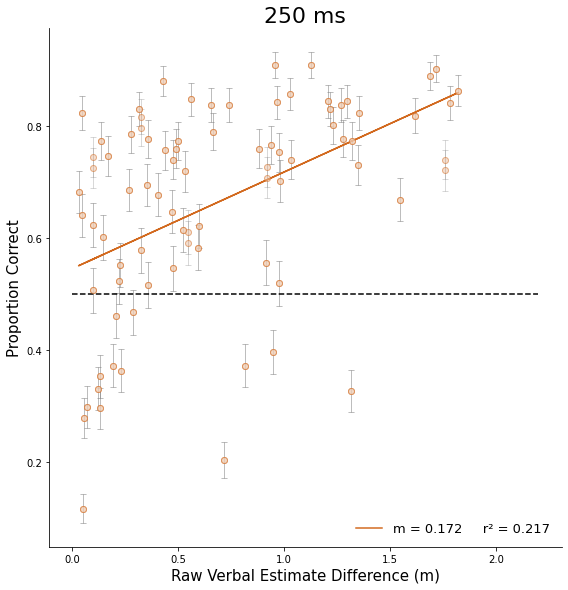

In [41]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


#run regression
VE_X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
VE_PC_250 = n_VE_accuracy_250
VE_PC_reg_250 = LinearRegression().fit(VE_X_250, VE_PC_250)

#Generated Predictions
PC_predicted_250 = VE_PC_reg_250.predict(VE_X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_250, VE_PC_250,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_250));


plt.plot(VE_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = 'm = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.xlabel("Raw Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

plt.plot([0, 2.2], [0.5,0.5], '--', color='black')



#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_250.coef_))
print("b: {0}".format(VE_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_250.score(VE_X_250, VE_PC_250))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('250 ms', fontsize=22)


plt.show();

In [834]:
n_stim.index('depth_discrimination_stimuli/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0-target.png')

        

39

m: [0.14722038]
b: 0.6259464140752607
R-squared:  0.2934184550732162


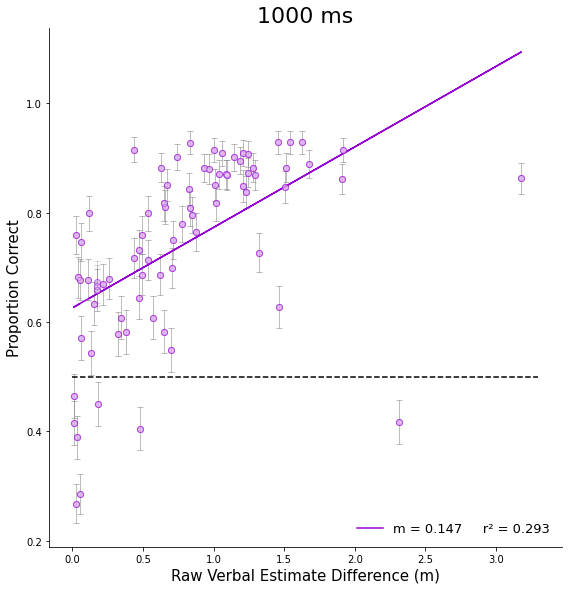

In [42]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


VE_X_1000 = np.array(np.abs(n_VE_estim_diff_1000).reshape(-1,1))
VE_PC_1000 = n_VE_accuracy_1000
VE_PC_reg_1000 = LinearRegression().fit(VE_X_1000, VE_PC_1000)

#Generated Predictions
PC_predicted_1000 = VE_PC_reg_1000.predict(VE_X_1000)
#Plot Our Actual and Predicted Values

r = np.sqrt(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)))

plt.errorbar(VE_X_1000, VE_PC_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_1000));
plt.plot(VE_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(VE_X_1000, PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(VE_PC_reg_1000.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)), 3)))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

plt.plot([0, 3.3], [0.5,0.5], '--', color='black')

# plt.plot(VE_X_1000[2], VE_PC_1000[2], 'o', color='black', alpha=1)

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_1000.coef_))
print("b: {0}".format(VE_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000))

plt.xlabel("Raw Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)


# plt.title("1000 ms: Accuracy", fontsize = 20)

# plt.xticks(np.arange(-1,1.2, 0.2))
# plt.yticks(np.arange(-1,1.2, 0.2))

fig.tight_layout()

plt.title('1000 ms', fontsize=22)


plt.show();

Text(0, 0.5, 'Proportion Correct')

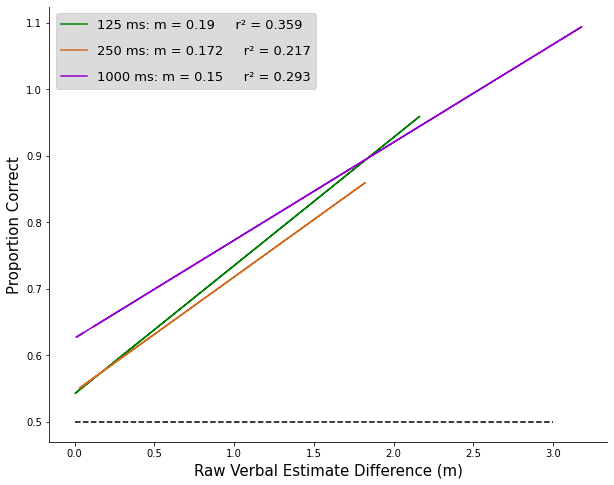

In [46]:
fig, ax = plt.subplots(figsize=[10,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.plot(VE_X_125, PC_predicted_125,color='green', label = '125 ms: m = ' + str(round(VE_PC_reg_125.coef_[0], 2))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_125.score(VE_X_125, VE_PC_125)), 3)))
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.plot(VE_X_1000, PC_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(VE_PC_reg_1000.coef_[0], 2))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)), 3)))

legend = plt.legend(loc = 0, fontsize=13, labelspacing=1, frameon=True, facecolor='lightgray')

plt.plot([0, 3], [0.5,0.5], '--', color='black')

plt.xlabel("Raw Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

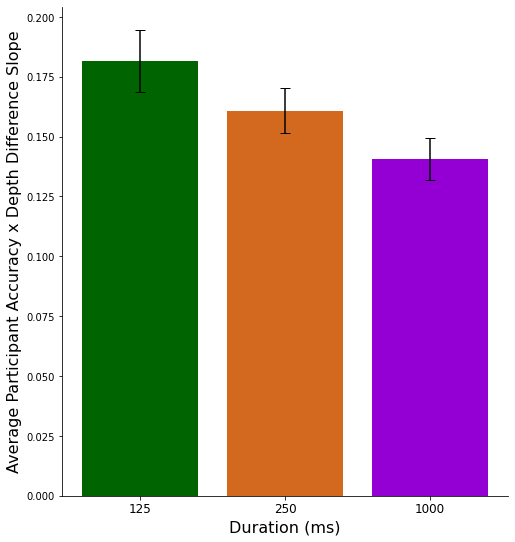

In [47]:
# creating the dataset
durations = ['125', '250', '1000']

zs_PC = [np.mean(all_subj_acc_slopes[125]), np.mean(all_subj_acc_slopes[250]), np.mean(all_subj_acc_slopes[1000])]
zs_PC_avg_sem = [sem(all_subj_acc_slopes[125]), sem(all_subj_acc_slopes[250]), sem(all_subj_acc_slopes[1000])]

fig, ax = plt.subplots(figsize=[8,9])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
# plt.ylim(0.15, 0.3)
# plt.yticks(np.arange(0.15, 0.35, 0.05),fontsize=12)



# creating the bar plot
plt.bar(durations, zs_PC, yerr = zs_PC_avg_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Participant Accuracy x Depth Difference Slope", fontsize=16)

plt.show()

In [48]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(all_subj_acc_slopes[125], all_subj_acc_slopes[250], all_subj_acc_slopes[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_acc_slopes[125], all_subj_acc_slopes[250])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_acc_slopes[125], all_subj_acc_slopes[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_acc_slopes[250], all_subj_acc_slopes[1000])
print(fvalue, pvalue)

3.8156838338515224 0.022732276836448146
1.702842712843928 0.1929133569406764
6.931969864868547 0.008903907714750085
2.508281324618485 0.11428230189405522


In [49]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(subj_acc[125], subj_acc[250], subj_acc[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(subj_acc[125], subj_acc[250])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(subj_acc[125], subj_acc[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(subj_acc[250], subj_acc[1000])
print(fvalue, pvalue)

7.399500300211817 0.0006881813219062871
0.05187484204417685 0.8199870751673
10.88876787874911 0.001083738854133062
10.441460525518492 0.0013664369600641217


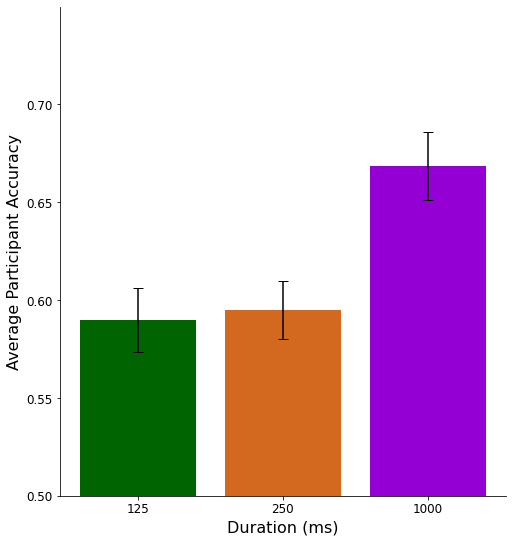

In [50]:
# creating the dataset
durations = ['125', '250', '1000']

zs_PC = [np.mean(subj_acc[125]), np.mean(subj_acc[250]), np.mean(subj_acc[1000])]
zs_PC_avg_sem = [sem(subj_acc[125]), sem(subj_acc[250]), sem(subj_acc[1000])]

fig, ax = plt.subplots(figsize=[8,9])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
plt.ylim(0.5, 0.75)
plt.yticks(np.arange(0.5, 0.75, 0.05),fontsize=12)



# creating the bar plot
plt.bar(durations, zs_PC, yerr = zs_PC_avg_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Participant Accuracy", fontsize=16)

plt.show()

In [51]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(n_VE_accuracy_125, n_VE_accuracy_250, n_VE_accuracy_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_VE_accuracy_125, n_VE_accuracy_250)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_VE_accuracy_125, n_VE_accuracy_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_VE_accuracy_250, n_VE_accuracy_1000)
print(fvalue, pvalue)

11.72437505026561 1.0774408525919692e-05
0.0009682429206264684 0.9751965733047828
20.921348343118737 6.927459708364887e-06
15.264030301017453 0.00011480112662254471


In [69]:
stats.pearsonr(n_VE_accuracy_250, n_VE_accuracy_125)

(0.47209328394040817, 4.92207061515194e-10)

In [70]:
stats.pearsonr(n_VE_accuracy_125, n_VE_accuracy_1000)

(0.6574447152596022, 1.1405127934839961e-20)

In [71]:
stats.pearsonr(n_VE_accuracy_250, n_VE_accuracy_1000)

(0.5397582839472645, 3.568722430947096e-13)

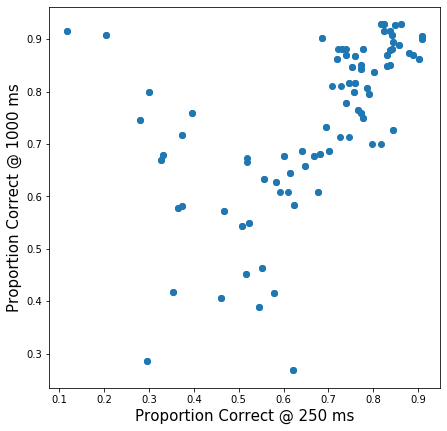

In [72]:
plt.figure(figsize=[7,7])
plt.xlabel('Proportion Correct @ 250 ms', fontsize=15)
plt.ylabel('Proportion Correct @ 1000 ms', fontsize=15)
plt.plot(n_VE_accuracy_250,n_VE_accuracy_1000, 'o' )

In [52]:
stats.pearsonr(n_VE_estim_diff_125, n_avg_RT_125)

(-0.4058825784168781, 1.4661772937168287e-07)

## RT

m: [-99.99303892]
b: 1447.9304867720741
R-squared:  0.17605387098593706


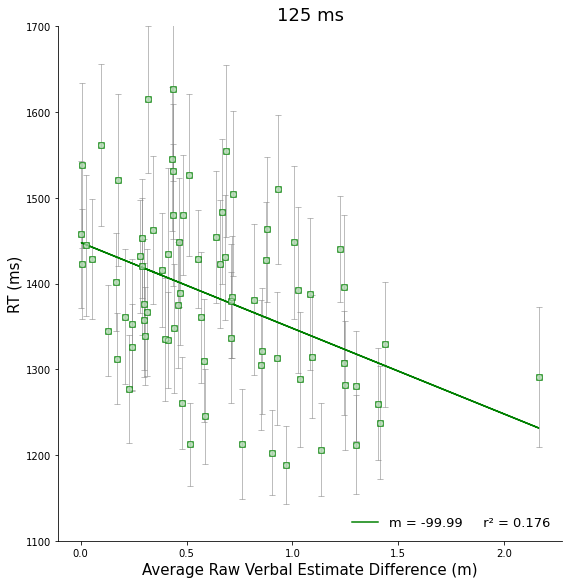

In [93]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_125 = np.array(np.abs(n_VE_estim_diff_125).reshape(-1,1))
y_125 = n_avg_RT_125
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(X_125, y_125,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_125));

plt.plot(X_125, y_125, 's', color='green', alpha = 0.3);
plt.plot(X_125, y_predicted_125,color='green', label = 'm = ' + str(round(reg_125.coef_[0], 2))
        + '     r' + get_super('2') + ' = '+ str(round(float(reg_125.score(X_125, y_125)), 3)))

plt.xlabel("Average Raw Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

plt.ylim(1100, 1700)

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('125 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

In [849]:
# n_avg_RT_250

In [86]:
stats.pearsonr(n_VE_estim_diff_250, n_avg_RT_250)

(-0.39450011322212886, 3.470983667926145e-07)

m: [-56.73554131]
b: 1328.696588922286
R-squared:  0.13662224162691472


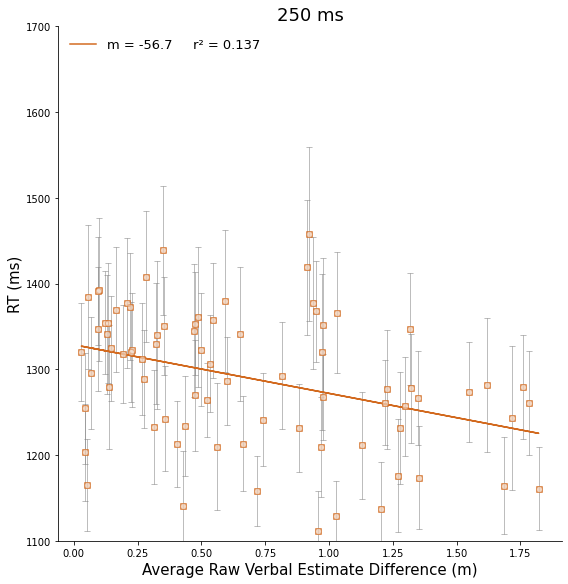

In [91]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
y_250 = n_avg_RT_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(X_250, y_250,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_250));

plt.plot(X_250, y_250, 's', color='chocolate', alpha = 0.3);
plt.plot(X_250, y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 1))
        + '     r' + get_super('2') + ' = '+ str(round(float(reg_250.score(X_250, y_250)), 3)))

plt.xlabel("Average Raw Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

plt.ylim(1100, 1700)


legend = plt.legend(loc = 2, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

# plt.xticks(np.arange(0.15,1.2, 0.2))
# plt.yticks(np.arange(6.7,7.3, .1))

plt.title('250 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

In [57]:
stats.pearsonr(n_VE_estim_diff_1000, n_avg_RT_1000)

(-0.4976939835206028, 3.842126342744134e-11)

m: [-32.17124369]
b: 1407.5058817911683
R-squared:  0.07585791375778961


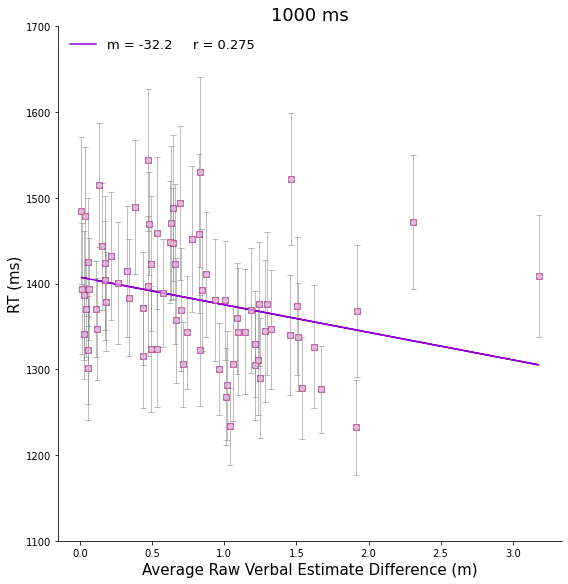

In [90]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_1000 = np.array(np.abs(n_VE_estim_diff_1000).reshape(-1,1))
y_1000 = n_avg_RT_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values

plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_1000));

r_1000 = np.sqrt(float(reg_1000.score(X_1000, y_1000)))

plt.plot(X_1000, y_1000, 's', color='darkviolet', alpha = 0.3);
plt.plot(X_1000, y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 1))
        + '     r = '+ str(round(float(r_1000), 3)))

plt.xlabel("Average Raw Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)
plt.ylim(1100, 1700)


legend = plt.legend(loc = 2, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

# plt.yticks(np.arange(6.7,7.3, .1))

plt.title('1000 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

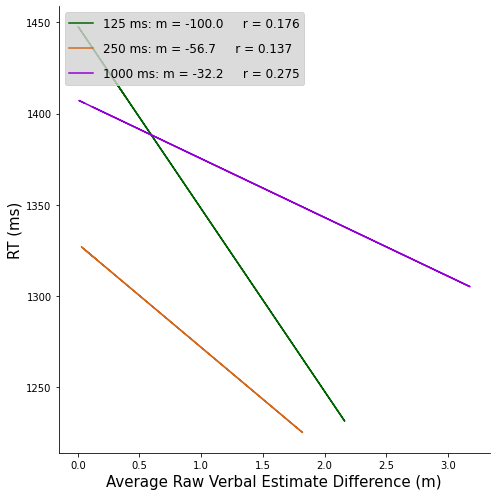

In [94]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.plot(X_125, y_predicted_125,color='darkgreen', label = '125 ms: m = ' + str(round(reg_125.coef_[0], 1))
        + '     r = '+ str(round(float(reg_125.score(X_125, y_125)), 3)))
plt.plot(X_250, y_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(reg_250.coef_[0], 1))
        + '     r = '+ str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.plot(X_1000, y_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(reg_1000.coef_[0], 1))
        + '     r = '+ str(round(float(r_1000), 3)))

plt.xlabel("Average Raw Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)
# plt.ylim(550, 1900)


legend = plt.legend(loc = 2, fontsize=12, labelspacing=1, frameon=True, facecolor='lightgray')

fig.tight_layout()



## Subject RT

In [65]:
# n_VE_estim_diff_250



In [103]:
all_mean_subj_RTs = {125: [], 250: [], 1000: []}

all_subj_RTs_slopes = {125: [], 250: [], 1000: []}


aks = {125: n_VE_answerkey_125, 250: n_VE_answerkey_250, 1000: n_VE_answerkey_1000}

for subj in final_discrim.subjID.unique():
    
    subj_df = final_discrim.loc[final_discrim['subjID']==subj]
    s_duration = subj_df.duration.unique()[0]
    
#     mean_subj_RTs = np.mean(np.array(subj_df['trial_RT']))
    mean_subj_RTs = np.mean(np.array(subj_df['trial_RT'])) - s_duration

    
    
    s_ak = aks[s_duration]
    
    s_stim = [elem for elem in subj_df.stimulus_0.unique() if type(elem) == str]
    
    subj_depthdiff = []
    subj_trialRT = []

    for stim0 in s_stim:
        stim_subj_df = subj_df.loc[subj_df['stimulus_0']==stim0]
        depthdiff = n_all_VE_discrim_performance[stim0]['VE_depthdifference_' + str(int(s_duration))]
        subj_depthdiff.append(depthdiff)
#         subj_trialRT.append(stim_subj_df.trial_RT.unique()[0])
        subj_trialRT.append(stim_subj_df.trial_RT.unique()[0]-s_duration)

        
    
    #run regression
    X = np.array(np.abs(subj_depthdiff).reshape(-1,1))
    y = subj_trialRT
    reg = LinearRegression().fit(X, y)

    all_subj_RTs_slopes[s_duration].append(reg.coef_[0])


        
    all_mean_subj_RTs[s_duration].append(mean_subj_RTs)


    
    

In [104]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(all_subj_RTs_slopes[125], all_subj_RTs_slopes[250], all_subj_RTs_slopes[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_RTs_slopes[125], all_subj_RTs_slopes[250])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_RTs_slopes[125], all_subj_RTs_slopes[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_RTs_slopes[250], all_subj_RTs_slopes[1000])
print(fvalue, pvalue)

5.468837887203176 0.004498550121752836
3.5586817963168564 0.06019720117593719
9.018775600013218 0.0028964290297677814
2.407468877441737 0.1217910837353914


In [105]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(all_mean_subj_RTs[125], all_mean_subj_RTs[250], all_mean_subj_RTs[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_mean_subj_RTs[125], all_mean_subj_RTs[250])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_mean_subj_RTs[125], all_mean_subj_RTs[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_mean_subj_RTs[250], all_mean_subj_RTs[1000])
print(fvalue, pvalue)

1.792114773863951 0.16778403832625702
2.5460970285254976 0.11161645293310203
1.1159586327054013e-08 0.9999157822011137
3.191942765185529 0.07499188869553738


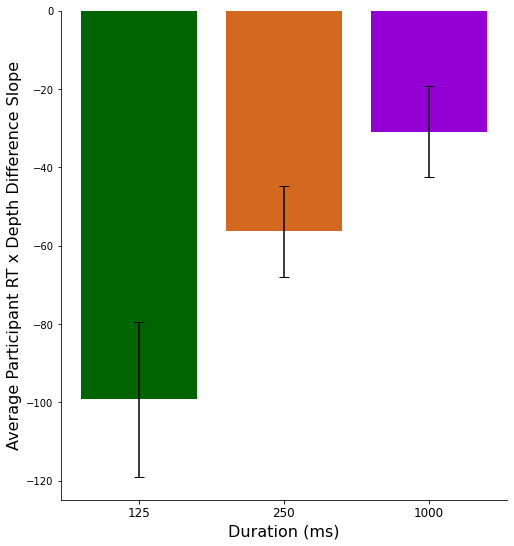

In [106]:
# creating the dataset
durations = ['125', '250', '1000']

zs_RT = [np.mean(all_subj_RTs_slopes[125]), np.mean(all_subj_RTs_slopes[250]), np.mean(all_subj_RTs_slopes[1000])]
zs_RT_avg_sem = [sem(all_subj_RTs_slopes[125]), sem(all_subj_RTs_slopes[250]), sem(all_subj_RTs_slopes[1000])]

fig, ax = plt.subplots(figsize=[8,9])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
# plt.ylim(1000, 2500)
# plt.yticks(np.arange(0.1, 0.35, 0.05),fontsize=12)


# creating the bar plot
plt.bar(durations, zs_RT, yerr = zs_RT_avg_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Participant RT x Depth Difference Slope", fontsize=16)

plt.show()

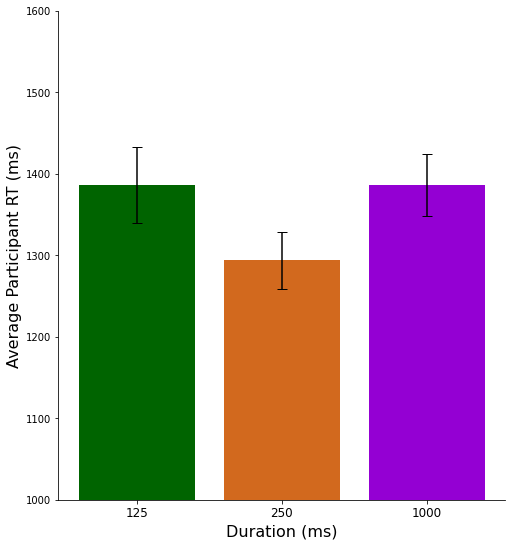

In [111]:
# creating the dataset
durations = ['125', '250', '1000']

zs_RT = [np.mean(all_mean_subj_RTs[125]), np.mean(all_mean_subj_RTs[250]), np.mean(all_mean_subj_RTs[1000])]
zs_RT_avg_sem = [sem(all_mean_subj_RTs[125]), sem(all_mean_subj_RTs[250]), sem(all_mean_subj_RTs[1000])]

fig, ax = plt.subplots(figsize=[8,9])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
plt.ylim(1000, 1600)
# plt.yticks(np.arange(0.1, 0.35, 0.05),fontsize=12)


# creating the bar plot
plt.bar(durations, zs_RT, yerr = zs_RT_avg_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Participant RT (ms)", fontsize=16)

plt.show()

In [112]:
# # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
# fvalue, pvalue = stats.f_oneway(n_avg_RT_125, n_avg_RT_250, n_avg_RT_1000)
# print(fvalue, pvalue)

# fvalue, pvalue = stats.f_oneway(n_avg_RT_125, n_avg_RT_250)
# print(fvalue, pvalue)

# fvalue, pvalue = stats.f_oneway(n_avg_RT_125, n_avg_RT_1000)
# print(fvalue, pvalue)

# fvalue, pvalue = stats.f_oneway(n_avg_RT_250, n_avg_RT_1000)
# print(fvalue, pvalue)